In [1]:
import sys
sys.path.append('..')
from src.data.docx  import read_docx,process_docx,find_content
import glob
import json
import os
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")
from src.models.pipeline import pipeline
from src.features.segment_transcript import CreateBlocks
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from gensim import similarities
import re
import statistics
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore")

# READ BOOKS OF VIDEOS

In [2]:
'''Defining CONSTS'''
docx_path = '../data/raw/docx'
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')
lemmatizing_method ='lemma' #'stemm'

In [3]:
videos_ids = list(map(lambda fl: fl.split('\\')[-1].split('.')[0],glob.glob(docx_path + '/*')))

In [4]:
desired_videos =['NuY7szYSXSw','XX7ePR21Ook','h9wxtqoa1jY','GJpt_3ie4WU','bTyxpoi2dmM']#['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ','zWg7U0OEAoE','tORLeHHtazM'] #['zWg7U0OEAoE','tORLeHHtazM'] #['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ']
videos_ids = list(filter(lambda x: x in desired_videos,videos_ids))

In [5]:
#video_docx = [glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0] for vid in videos_ids]
#docx_db =[read_docx(path) for path in video_docx]
videos_ids

['bTyxpoi2dmM', 'GJpt_3ie4WU', 'h9wxtqoa1jY', 'NuY7szYSXSw', 'XX7ePR21Ook']

In [6]:
f_read = {
    'statbook':'statbook',
    'Dsa':'Dsa',
    'MIT6_042JF10_notes':'MIT6_042JF10_notes'
}

docxs_chapter_keyword = {
    'statbook':'Topic',
    'Dsa': 'Chapter',
    'MIT6_042JF10_notes':'Chapter'
}

In [7]:
video_to_paper = {}
paper_content ={}
for vid in videos_ids:
    doc_path = glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0]
    doc_name = doc_path.split('\\')[-1].split('.')[0]
    video_to_paper[vid] = doc_name    
    if doc_name not in paper_content.keys():    
        full_text,font_sizes = read_docx(doc_path)
        paper_content[doc_name] = find_content(f_read[doc_name],
                                               full_text,
                                               font_sizes,
                                               docxs_chapter_keyword[doc_name],
                                              lemmatizing=lemmatizing_method)

# RESTORE RESULTS FROM TRAINING

In [8]:
'''Select transcript for only wanted videos'''
transcript_filespath = list(filter(lambda x: x.split('\\')[-1].split('.')[0] in videos_ids,transcript_filespath))

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''
def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec
for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])
    

'''Get parameters from training'''
df_results = pd.read_csv('../data/processed/bayesian_opt/phrases/lemmas_adv_propn.csv')
n_largest_res = 3
pipeline_results = df_results[df_results['video'].isin(videos_ids)]\
                .groupby('video')[['video','workflow','params','max_target']]\
                .apply(lambda grp: grp.nlargest(n_largest_res,'max_target')).values.tolist()

pipeline_results = pipeline_results[:-1]#this is for zWg7U0OEAoE

    
    
    
def boundryevaluation(curresults,ground_base,accurrcy_shift = 30):
        true_positive = 0
        false_negative = 0
        false_positive = 0 
        true_positive_list_debug = []
        #false_negative_list_debug = []
        false_positive_list_debug = []
        results = curresults[:]
        
        
        #print('curresults %s' %(curresults))
        #print('ground_base %s ' %(ground_base))
        
        for grb in ground_base:
            is_false_positive = True
            for res in results:     
                if abs(res - grb) < accurrcy_shift:
                    is_false_positive = False
                    true_positive_list_debug.append(res)
                    true_positive+=1
                    results.remove(res)
                    break   
            if is_false_positive:
                false_positive_list_debug.append(grb)
                false_positive+=1
                
        #print("TP: " + str(true_positive_list_debug))
        #print("FP: " + str(false_positive_list_debug))
        #print("FN: " + str(curresults))
        #print('true_positive : %s ' %(true_positive))
        false_negative = len(results) # make sure the true positive are removed from here 
        recall_rate = true_positive/(true_positive + false_negative )
        precision_rate = true_positive/(true_positive + false_positive)
        #print("TP: %s , FP: %s, FN: %s" %(true_positive,false_positive,false_negative))
        #print("precision rate : %s, recall rate : %s " % (precision_rate,recall_rate))
        return precision_rate

    


In [9]:
videos_division = {}

for vid in videos_ids:
    vid_results = list(filter(lambda x: x[0] == vid,pipeline_results))
    max_precision = 0
    vid_words = None
    vid_shifts = None
    for result in vid_results:
        '''From the get optimized by bayesian we get that for the video '''
        vid = result[0]
        params = ast.literal_eval(result[2]) #{'n_clusters': 18, 'sim_thresh': 0.6, 'step_size': 49, 'window_size': 150}
        #print(params)
        for key in ['n_clusters','step_size','window_size']:
            params[key] = int(params[key])# - 1
        workflow = result[1] #'sliding_window-tfidf-cosine-median_(3,3)-spectral_clustering'
        
        shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
        groundbase = shifts[:-1]
        transcripts = transcripts_jsons[vid]
        #print(grounbase)
        _pipeline = workflow.split('-')
        filter_type = None
        mask_shape = None
        filtering = _pipeline[3]
        if filtering != 'None':
            filter_type = filtering.split('_')[0]
            mask_shape = ast.literal_eval(filtering.split('_')[1])
        '''This running may not work at first time do not give up and run it couple of times'''

        '''print('Running the following %s for video %s with params %s %s %s'
              %(workflow, vid,params,filter_type,mask_shape))'''
        #print(vid_results[1])
        #print(str(filter_type) + " " + str(mask_shape))
        shift_times,topic_words = (None,None)
        n_trials = 7
        while shift_times is None and topic_words is None and n_trials > 0:
            print('##################################################')
            print("running trial %s for vid %s desired precision %s "%(n_trials,vid,result[3]))
            n_trials= n_trials - 1
            shift_times,topic_words = pipeline.run_for_baye(groundbase,
                                                            transcripts,
                                                            slicing_method='sliding_window',
                                                            window_size=params['window_size'],#59
                                                            step_size_sd= params['step_size'], #10
                                  vector_method='tfidf',vectorizing_params=None,
                                  similarity_method='cosine',
                                  filter_params={"filter_type":filter_type,
                                                 "mask_shape":mask_shape,
                                                 "sim_thresh": params['sim_thresh'], #0.5160973480326474 
                                                 "is_min_thresh":True
                                                 },
                                 clustering_params={
                                         'algorithm':'spectral_clustering',
                                         'n_clusters':params['n_clusters'] #14
                                         },
                                        accurrcy_shift=30,
                                        return_value='division') or (None,None)

            if shift_times is not None:
                pr = boundryevaluation(shift_times,groundbase,accurrcy_shift=45)
                print("output precision %s " %(pr))
                
                if pr > max_precision:
                    print("new high percision caught")
                    max_precision = pr 
                    vid_words = topic_words
                    shift_times.append('end')
                    vid_shifts = shift_times 
                if pr < result[3]:
                    shift_times,topic_words = (None,None)    

    videos_division[vid] = {'topic_words':vid_words,'topic_shift':vid_shifts}

##################################################
running trial 7 for vid bTyxpoi2dmM desired precision 0.875 
The results:
[91, 279, 433, 613, 753, 872, 1039, 1240, 1444, 1647, 1802, 1941, 2100, 2288, 2473, 2632, 2829, 3012, 3130, 3233, 3387, 3569, 3647, 3762, 3891, 4214, 4646, 4989]
The ground base:
[90, 360, 665, 885, 985, 1620, 2233, 3220]
output precision 0.5 
new high percision caught
##################################################
running trial 6 for vid bTyxpoi2dmM desired precision 0.875 
label 8 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 8 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 5 for vid bTyxpoi2dmM desired precision 0.875 
The results:
[91, 264, 418, 613, 764, 913, 1069, 1252, 1423, 1602, 1764, 1926, 2100, 2288, 2473, 2611, 2829, 3061, 3200, 3337, 3451, 3647, 3852, 4009, 4271, 4553, 4764, 4989]
The ground base:
[90, 360, 665, 885, 985, 1620, 2233, 3220]
output precision 0.5 
##################################################
running trial 4 for vid bTyxpoi2dmM desired precision 0.875 
label 7 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 7 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 3 for vid bTyxpoi2dmM desired precision 0.875 
label 24 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 24 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 2 for vid bTyxpoi2dmM desired precision 0.875 
The results:
[91, 279, 433, 613, 764, 902, 1083, 1423, 1619, 1790, 1926, 2100, 2269, 2418, 2594, 2803, 3028, 3147, 3297, 3437, 3578, 3762, 3891, 4200, 4463, 4646, 4764, 4989]
The ground base:
[90, 360, 665, 885, 985, 1620, 2233, 3220]
output precision 0.5 
##################################################
running trial 1 for vid bTyxpoi2dmM desired precision 0.875 
label 4 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 4 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 7 for vid bTyxpoi2dmM desired precision 0.75 
The results:
[113, 190, 332, 433, 633, 840, 954, 1196, 1368, 1526, 1733, 1913, 2011, 2204, 2358, 2604, 2767, 2999, 3190, 3350, 3551, 3707, 3995, 4153, 4382, 4610, 4984]
The ground base:
[90, 360, 665, 885, 985, 1620, 2233, 3220]
output precision 0.75 
new high percision caught
##################################################
running trial 7 for vid bTyxpoi2dmM desired precision 0.75 
The results:
[95, 294, 462, 628, 770, 927, 1061, 1256, 1429, 1621, 1795, 1932, 2103, 2259, 2484, 2648, 2836, 3055, 3169, 3261, 3440, 3610, 3783, 4014, 4187, 4561, 4737, 4973]
The ground base:
[90, 360, 665, 885, 985, 1620, 2233, 3220]
output precision 0.75 
##################################################
running trial 7 for vid GJpt_3ie4WU desired precision 1.0 
The results:
[128, 339, 599, 790, 955, 1119, 1206, 1354, 1464, 1644, 1854, 2092, 2393, 2650, 2713, 2811, 3002, 3095, 3350, 3599

Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 0 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 3 for vid GJpt_3ie4WU desired precision 0.7142857142857143 
The results:
[160, 385, 738, 1002, 1161, 1206, 1306, 1464, 1644, 1919, 2092, 2393, 2650, 2811, 2933, 3095, 3350, 3599, 3817, 4024, 4180, 4337, 4605, 4821]
The ground base:
[324, 733, 855, 1015, 1135, 1820, 2673]
output precision 0.5714285714285714 
##################################################
running trial 2 for vid GJpt_3ie4WU desired precision 0.7142857142857143 
The results:
[160, 339, 678, 892, 1055, 1206, 1354, 1464, 1644, 1854, 2166, 2393, 2650, 2811, 2933, 3095, 3350, 3556, 3817, 4024, 4180, 4337, 4605, 4767]
The ground base:
[324, 733, 855, 1015, 1135, 1820, 2673]
output precision 0.7142857142857143 
##################################################
running trial 7 for vid GJpt_3ie4WU desired precision 0.7142857142857143 
The results:
[89, 265, 442, 698, 840, 1013, 1188, 1344, 1455, 1624, 1838, 2072, 2343, 2610, 2767, 2921, 3042, 3258, 3358, 3

Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 21 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 5 for vid NuY7szYSXSw desired precision 0.875 
label 0 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 0 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 4 for vid NuY7szYSXSw desired precision 0.875 
The results:
[189, 291, 450, 585, 811, 1034, 1251, 1343, 1507, 1729, 1900, 2042, 2174, 2384, 2537, 2664, 2886, 3037, 3142, 3286, 3377, 3509, 3748, 4103, 4297, 4466, 4811]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.625 
##################################################
running trial 3 for vid NuY7szYSXSw desired precision 0.875 
The results:
[189, 251, 373, 496, 703, 868, 1194, 1292, 1507, 1688, 1774, 1956, 2123, 2222, 2438, 2537, 2664, 2886, 3037, 3240, 3377, 3564, 3811, 4062, 4297, 4466, 4811]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.5 
##################################################
running trial 2 for vid NuY7szYSXSw desired precision 0.875 
The results:
[189, 251, 341, 450, 496, 585, 703, 868, 1194, 1292, 1464, 1688, 1900, 2042, 2222, 2438, 2664, 2827, 2994, 3089, 3240, 3331, 3509, 

Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 23 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 7 for vid NuY7szYSXSw desired precision 0.75 
The results:
[158, 248, 325, 400, 505, 659, 864, 1113, 1271, 1473, 1737, 1975, 2165, 2365, 2551, 2807, 2990, 3137, 3328, 3505, 3680, 4073, 4332, 4581, 4814]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.5 
##################################################
running trial 6 for vid NuY7szYSXSw desired precision 0.75 
The results:
[158, 248, 369, 505, 641, 822, 1113, 1271, 1473, 1697, 1870, 2041, 2195, 2347, 2506, 2723, 2963, 3105, 3310, 3492, 3580, 3992, 4332, 4606, 4814]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.625 
##################################################
running trial 5 for vid NuY7szYSXSw desired precision 0.75 
The results:
[145, 241, 334, 475, 641, 864, 1113, 1271, 1473, 1726, 1916, 2052, 2204, 2365, 2531, 2743, 2990, 3124, 3328, 3505, 3680, 4073, 4315, 4503, 4814]
The ground base

In [10]:
#videos_division

# EXTRACT MAIN CHAPTERS OF BOOKS AND ORAGANIZE THE PAPER AS DIFFERENT DOCUMENTS GROUPS

In [11]:
paper_content[doc_name].keys()

dict_keys(['corpus', 'titles', 'main titles'])

In [12]:
'''Find the following for each paper:
    1) main chapter title index. for example [10,15....]
    2) range of subsection within each main chapter . for example [(0,9),(11,14)...]
    
    '''

paper_mainchapter_indexes = {}
paper_sec_within_main_indexes = {}
paper_mains_as_one_doc = {}
paper_subsec_as_one_doc = {}

for doc_name in paper_content.keys():
    '''Find the main chapter indexes in the list of the overall titles'''
    mainchapter_indexes = [paper_content[doc_name]['titles'].index(ch_title)
                           for ch_title in paper_content[doc_name]['main titles']]
    '''Find the subsection indexes range within each main chapter '''
    subsec_mainchapter_indexes = [range(mainchapter_indexes[index],mainchapter_indexes[index + 1])
                                  for index in range(len(mainchapter_indexes) - 1)]
    subsec_mainchapter_indexes.append(range(mainchapter_indexes[-1],
                                            len(paper_content[doc_name]['titles'])))
    paper_mainchapter_indexes[doc_name] = mainchapter_indexes
    paper_sec_within_main_indexes[doc_name] = subsec_mainchapter_indexes
    
    
    '''Making each chapter as a one documents'''
    
    '''Union all the documents in a section into single document'''
    paper_subsec_as_one_doc[doc_name] = [list(reduce(lambda doc,acc:doc + acc,sec,[]))
                                         for sec in paper_content[doc_name]['corpus']]
    '''Union all the sub section in a main chapter into one document'''
    paper_mains_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                    paper_subsec_as_one_doc[doc_name][s_i]+acc,subsec_indexes,[]))
                                        for subsec_indexes in paper_sec_within_main_indexes[doc_name]]

In [13]:
#paper_subsec_as_one_doc['statbook'][0]

In [14]:
'''Debug'''
"""
print(paper_content['statbook']['main titles'])
print((paper_content['statbook']['titles']))
print(len(paper_content['statbook']['titles']))# 
print(len(paper_content['statbook']['corpus']))#members of each element:section corpus
print(len(paper_content['statbook']['corpus'][0]))#members of each element: documents
print(len(paper_content['statbook']['corpus'][0][0])) #of each element words
print(paper_sec_within_main_indexes['statbook'])


#debug
print(sum([len(paper_subsec_as_one_doc['statbook'][s]) for s in range(0,10)]))
print(len(paper_mains_as_one_doc['statbook'][0]))
print(len(paper_mains_as_one_doc['statbook']))



"""
"""#print(len(paper_subsec_as_one_doc['statbook']))
print((subsec_mainchapter_indexes))
print(len(paper_content['Dsa']['titles']))
print(len(paper_subsec_as_one_doc[doc_name]))
print(len(paper_sec_within_main_indexes[doc_name]))
print(paper_content['Dsa']['titles'][-1])
print(paper_subsec_as_one_doc[doc_name][-2])
"""
"""print(paper_content['Dsa']['main titles'][0])
print(len(paper_mains_as_one_doc['Dsa'][0][0]))
print((paper_mains_as_one_doc['Dsa'][0][0]))
#print(len(paper_sec_within_main_indexes['Dsa'][0][0]))
print(len(paper_subsec_as_one_doc['Dsa'][0]))
print((paper_subsec_as_one_doc['Dsa'][0][0]))
print(len(videos_division['tORLeHHtazM']['topic_words'][0][0]))
print((videos_division['tORLeHHtazM']['topic_words'][0][0]))"""

#paper_content['Dsa']['corpus']
#print((paper_mains_as_one_doc['Dsa'][0][0]))

"print(paper_content['Dsa']['main titles'][0])\nprint(len(paper_mains_as_one_doc['Dsa'][0][0]))\nprint((paper_mains_as_one_doc['Dsa'][0][0]))\n#print(len(paper_sec_within_main_indexes['Dsa'][0][0]))\nprint(len(paper_subsec_as_one_doc['Dsa'][0]))\nprint((paper_subsec_as_one_doc['Dsa'][0][0]))\nprint(len(videos_division['tORLeHHtazM']['topic_words'][0][0]))\nprint((videos_division['tORLeHHtazM']['topic_words'][0][0]))"

In [15]:
'''Find phrasers of books  '''
paper_phrasers = {}
for doc_name in paper_mains_as_one_doc.keys():
    paper_phrasers[doc_name] = list(set(reduce(lambda acc,x: acc+x,
                                      [[w for w in ch if '_' in w]
                                      for ch in paper_mains_as_one_doc[doc_name]])))

In [16]:
#paper_phrasers['Dsa']

# FIND CORRELATION BETWEEN MAIN CHAPTERES AND FOUNDED TOPICS IN THE VIDEO 

In [17]:
def find_top_words_of_topic(topic_words,chapter_titles=None):
    for tp_i,tp_words in enumerate(topic_words):
        #
        raw_text = ' '.join(tp_words)
        myvectorizer = CountVectorizer()
        mytf = myvectorizer.fit_transform([raw_text]).toarray()
        #print(mytf)
        maxes = heapq.nlargest(3,mytf[0])
        indexes = []
        for i,bal in enumerate(mytf[0]):
            if bal in maxes:
                indexes.append(i)
        ws = [myvectorizer.get_feature_names()[_] for i,_ in enumerate(indexes)]
        
        if chapter_titles is None:
            print('top words for topic %s are %s' %(tp_i,ws))
        else:
            print('top words for topic %s are %s' %(chapter_titles[tp_i],ws))

In [18]:
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import spacy
from nltk.stem import PorterStemmer
stop_words = stopwords.words('english')
nlp = spacy.load('en',disable=['parser','ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB','PROPN','ADV']#['NOUN', 'ADJ', 'VERB','ADV']#['NOUN', 'ADJ', 'VERB','PROPN']# #['NOUN', 'ADJ', 'VERB']
porter = PorterStemmer()

In [19]:
def emphasize_title(doc_name,book_chapters,titles,factor_enrich = 20,lemmatizing = "lemma"):
    chapters_enriched = book_chapters[:]
    
    for index,tl in enumerate(titles):
        tl_text_no_punc = simple_preprocess(tl,deacc=True) 
        tokenized_text_non_stop_words = [ word for word in tl_text_no_punc 
                                         if word not in stop_words]
        """text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
        tokenized_lemmas = nlp(text_non_stop_words)
        tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                            if token.pos_ in allowed_postags]"""
        
        if lemmatizing == "stemm":
            tokenized_lemmas = [porter.stem(w) for w in tokenized_text_non_stop_words]
        else:
            text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
            tokenized_lemmas = nlp(text_non_stop_words)
            tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                                if token.pos_ in allowed_postags]

        
        
        tokenized_lemmas_ph = '_'.join(tokenized_lemmas)#reduce(lambda acc,x: acc+x,
        #print('tokenized_lemmas_ph %s' %(tokenized_lemmas_ph))
        
        if tokenized_lemmas_ph in paper_phrasers[doc_name]:
            tokenized_lemmas =[tokenized_lemmas_ph]
        
        chapters_enriched[index] = chapters_enriched[index] + tokenized_lemmas * factor_enrich
    return chapters_enriched

In [20]:
def get_topic_chapter_corr_tfidf(paper_name,book_chapters,
                                 vid_topics_words,vid_topics_shift,
                                 dispaly_titles,pre_labeled_title=None):
    raw_book_video = []
    for tp_vid in vid_topics_words:
        raw_book_video = raw_book_video + [tp_vid]
    
    for ch in book_chapters:
        raw_book_video = raw_book_video + [ch]

    # creating dictionary of all of the words in the corpus of the video and the paper
    #print(len(raw_book_video))
    dictionary = Dictionary(raw_book_video)
    #dictionary = Dictionary(book_chapters)
    
    #ch_dict = Dictionary(book_chapters)
    #vid_dict = Dictionary(vid_topics_words)
    
    the_dictionary = dictionary
    
    #whole_corpus = vid_topics_words + book_chapters
    #bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
    bgw_chapter = [the_dictionary.doc2bow(doc) for doc in book_chapters]
    bgw_vids = [the_dictionary.doc2bow(doc) for doc in vid_topics_words]
    
    '''Calculate the pivot '''
    _tmp =  [len(list(set([w for w in ch]))) for ch in book_chapters]
    book_pivot = sum(_tmp)/len(_tmp)
    _tmp = [len(list(set([w for w in ch]))) for ch in vid_topics_words]
    vid_pivot = sum(_tmp)/len(_tmp)
    
    tf_idf_model_ch = models.TfidfModel(bgw_chapter,
                                        dictionary=the_dictionary#,
                                        #pivot=book_pivot#,
                                        #slope=0.8,
                                        #smartirs='nnc'
                                       ) #,
    tf_idf_model_vid = models.TfidfModel(bgw_vids,
                                         dictionary=the_dictionary#,
                                         #pivot=vid_pivot#,
                                         #slope=0.4
                                        )#,smartirs='lfc'
    
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model_ch[bgw_chapter],
                                                    num_features=len(the_dictionary))
    
    correlation = [[s for s in index_sim[tf_idf_model_vid[doc]]] for doc in bgw_vids]
    #print(tf_idf_model[bgw_vids])
    
    # find the top n words in the topic (in the video)
    #print('$$$$$$$$$$$$$$top words of video topic$$$$$$$$$$$$$$')
    #find_top_words_of_topic(videos_division[vid]['topic_words'])
    #print('$$$$$$$$$$$$$$top words of book chapters$$$$$$$$$$$$$$')
    #find_top_words_of_topic(book_chapters,chapter_titles=dispaly_titles)
    
    
    
    # normalizing the correlation between each topic and chapter 
    for i_t in range(len(correlation)):
        sum_ = sum(correlation[i_t])
        for ch_index in range(len(correlation[i_t])):
            correlation[i_t][ch_index] = correlation[i_t][ch_index]/sum_
    
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] ) # to get the global max in min
    sns.heatmap(correlation,vmin=min(corr_as_row),vmax=max(corr_as_row))
    plt.show()
    
    
    
    # find the cha
    ch_matching_top = []
    #print(len(correlation[0]))
    
    
    for i,corr in enumerate(correlation):
        max_cor = max(corr) # max correlation with that topic
        shift = vid_topics_shift[i]
        founded_title = dispaly_titles[corr.index(max_cor)]
        #ch_matching_top.append(paper_mainchapter_indexes[paper_name][corr.index(max_cor)])
        ch_matching_top.append(founded_title)

    
    
    hit = 0 
    miss = 0
    
    if pre_labeled_title is not None:
        print(vid)
        shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
        groundbase = shifts#[:-1] # not removing the end string - modify it in the next lines
        vid_topics_shift[-1] = groundbase[-1] # converting the 'end' string to 
        df_vid_results = pd.DataFrame(columns=['Video',
                                               'Video Shift',
                                               'Founded Title',
                                               'Similarity Ratio',
                                               'Chapter Section',
                                               'Prelabeled Title',
                                               'Labeling Confidence'])
        for i,corr in enumerate(correlation):
            max_cor = max(corr) # max correlation with that topic
            shift = vid_topics_shift[i]
            closest_grb_index = 0
            for grb_i in range(len(groundbase)):
                if abs(int(groundbase[grb_i])- shift) < abs(int(groundbase[closest_grb_index]) - shift):
                    closest_grb_index = grb_i
            
            founded_title = dispaly_titles[corr.index(max_cor)]
            df_vid_results = df_vid_results.append({
                                   'Video' :vid,
                                   'Video Shift': sec_to_min(shift),
                                   'Founded Title':founded_title,
                                   'Similarity Ratio':max_cor,
                                   'Chapter Section':pre_labeled_title[closest_grb_index][0],
                                   'Prelabeled Title':pre_labeled_title[closest_grb_index][1],
                                   'Labeling Confidence':pre_labeled_title[closest_grb_index][2]},ignore_index=True)

        display(HTML(df_vid_results[['Video Shift',
                                    'Founded Title',
                                    'Similarity Ratio',
                                    'Chapter Section',
                                    'Prelabeled Title',
                                    'Labeling Confidence']].to_html()))
    else:
        for i,corr in enumerate(correlation):
            max_cor = max(corr) # max correlation with that topic
            shift = vid_topics_shift[i]
            print (" video_shift index %s at %s , chapter title %s ( index %s) " 
                   %(i,
                     sec_to_min(shift),
                     dispaly_titles[corr.index(max_cor)],
                     corr.index(max_cor)
                     ))

    return ch_matching_top,correlation

def find_dominent_main_chapter(ch_tp_corr,titles,correlation):
    
    '''Find the frequency of each chapter'''
    chapter_matching_counts_max = [max([ch_tp_corr.count(ch) for ch in ch_tp_corr])]
    for max_count in chapter_matching_counts_max:
        #print("####### #######")
        '''Find the most frequent chapter'''
        #print(([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        dominent_chapters = list(set([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        #print(dominent_chapters)
        
        # if we have absulote majority on topic
        if len(dominent_chapters) == 1:
            return dominent_chapters[0]
        else:
            # draw between topics, decide which one by taking this with the high variance
            index_winner = 0
            df_ch_corr = pd.DataFrame.from_records(correlation)
            for j_dom in range(len(dominent_chapters)):
                first = df_ch_corr.var()[titles.index(dominent_chapters[index_winner])]
                #print(first)
                second = df_ch_corr.var()[titles.index(dominent_chapters[j_dom])]
                #print(second)
                if first > second:
                    index_winner = j_dom
            return (dominent_chapters[index_winner])
        
            
        
def sec_to_min(seconds):
    if seconds == 'end':
        return 'end'
    return ("%02d:%02d"%(seconds//60,seconds%60))

# correlations : correaltions of all levels
def measure_confidence(vid,correlations):
    n_vid_topic = len(correlations[0]) # number of video topics that were found
    topics_errs = []
    for topic_index in range(n_vid_topic):
        topic_pr = 0
        for map_index,correlation_map in enumerate(correlations):
            '''Calculate soft max on the correlation of the current topic to the chapters'''
            #print('correlation %s map %s' % (topic_index,correlation_map[topic_index]))
            sum_ = sum(correlation_map[topic_index])
            max_corr_ch_val = max(correlation_map[topic_index])
            #most_corr_ch_index = correlation_map[topic_index].index(max_corr_ch_val)
            most_corr_ch_val = max_corr_ch_val/sum_
            #print('max_val : %s sum_ : %s value from softmax : %s '%(max_corr_ch_val,sum_,most_corr_ch_val))
            '''scaling the max value by the cosine value of the max correlated'''
            most_corr_ch_val = most_corr_ch_val * max_corr_ch_val
            '''adding and scaling the given value to the overall rate of the topic'''
            topic_pr += (2**(-(map_index - 1))) * most_corr_ch_val
        print("For topic number %s the confidence is %s " % (topic_index,topic_pr))
        topics_errs.append(topic_pr)

In [21]:
'''my hand tuning data frame'''

df_tp_to_ch = pd.read_csv(os.path.join(groundbase_dir,'Topic to chapter.csv'))
df_tp_to_ch  = df_tp_to_ch.replace({np.nan:None})

################ bTyxpoi2dmM ################


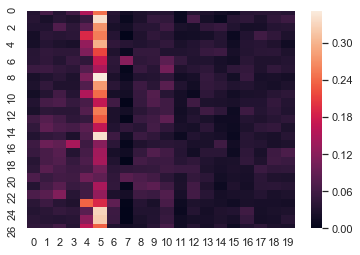

 video_shift index 0 at 01:53 , chapter title Directed Graphs ( index 5) 
 video_shift index 1 at 03:10 , chapter title Directed Graphs ( index 5) 
 video_shift index 2 at 05:32 , chapter title Directed Graphs ( index 5) 
 video_shift index 3 at 07:13 , chapter title Directed Graphs ( index 5) 
 video_shift index 4 at 10:33 , chapter title Directed Graphs ( index 5) 
 video_shift index 5 at 14:00 , chapter title Directed Graphs ( index 5) 
 video_shift index 6 at 15:54 , chapter title Directed Graphs ( index 5) 
 video_shift index 7 at 19:56 , chapter title Directed Graphs ( index 5) 
 video_shift index 8 at 22:48 , chapter title Directed Graphs ( index 5) 
 video_shift index 9 at 25:26 , chapter title Directed Graphs ( index 5) 
 video_shift index 10 at 28:53 , chapter title Directed Graphs ( index 5) 
 video_shift index 11 at 31:53 , chapter title Directed Graphs ( index 5) 
 video_shift index 12 at 33:31 , chapter title Directed Graphs ( index 5) 
 video_shift index 13 at 36:44 , ch

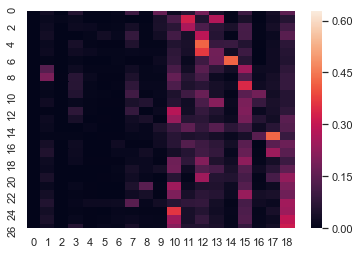

bTyxpoi2dmM


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,01:53,6.3.3 Network Diameter,0.190845,6.3,Communication Networks,None
1,03:10,6.3.2 The Complete Binary Tree,0.323753,6.3,Communication Networks,None
2,05:32,6.3.2 The Complete Binary Tree,0.265256,6.3.2,The Complete Binary Tree,None
3,07:13,6.3.3 Network Diameter,0.291090,6.3.2,The Complete Binary Tree,None
4,10:33,6.3.3 Network Diameter,0.423382,6.3.3,Network Diameter,None
5,14:00,6.3.3 Network Diameter,0.367924,6.3.4,Switch Size,None
6,15:54,6.3.5 Switch Count,0.422019,6.3.5,Switch Count,None
7,19:56,6.3.6 Congestion,0.246444,6.3.5,Switch Count,None
8,22:48,6.1 Definitions,0.197205,6.3.6,Congestion,None
9,25:26,6.3.6 Congestion,0.341821,6.3.6,Congestion,None


################ GJpt_3ie4WU ################


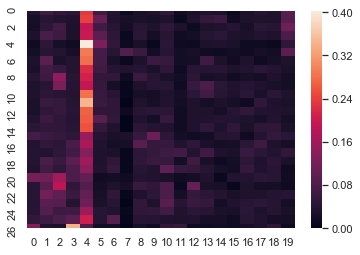

 video_shift index 0 at 02:40 , chapter title Graph Theory ( index 4) 
 video_shift index 1 at 05:39 , chapter title Graph Theory ( index 4) 
 video_shift index 2 at 07:55 , chapter title Graph Theory ( index 4) 
 video_shift index 3 at 12:18 , chapter title Graph Theory ( index 4) 
 video_shift index 4 at 14:52 , chapter title Graph Theory ( index 4) 
 video_shift index 5 at 17:35 , chapter title Graph Theory ( index 4) 
 video_shift index 6 at 19:21 , chapter title Graph Theory ( index 4) 
 video_shift index 7 at 21:46 , chapter title Graph Theory ( index 4) 
 video_shift index 8 at 24:24 , chapter title Graph Theory ( index 4) 
 video_shift index 9 at 27:24 , chapter title Graph Theory ( index 4) 
 video_shift index 10 at 30:54 , chapter title Graph Theory ( index 4) 
 video_shift index 11 at 34:52 , chapter title Graph Theory ( index 4) 
 video_shift index 12 at 40:34 , chapter title Graph Theory ( index 4) 
 video_shift index 13 at 44:10 , chapter title Graph Theory ( index 4) 
 v

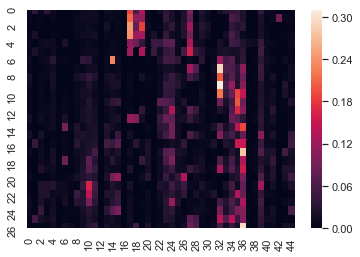

GJpt_3ie4WU


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,02:40,5.4.1 Paths and Walks,0.188469,5.4.1,Paths and Walks,None
1,05:39,5.4.1 Paths and Walks,0.208424,5.4.1,Paths and Walks,None
2,07:55,5.4.1 Paths and Walks,0.245042,5.4.1,Paths and Walks,None
3,12:18,5.4.1 Paths and Walks,0.240521,5.4.2,Finding a Path,None
4,14:52,5.6.1 Cycles and Closed Walks,0.130565,5.5,Connectivity,None
5,17:35,5.6.1 Cycles and Closed Walks,0.161813,5.6.1,Cycles and Closed Walks,None
6,19:21,5.3.2 Degree-Bounded Coloring,0.230665,5.7.1,Definitions,None
7,21:46,5.7 Trees,0.292068,5.7.1,Definitions,None
8,24:24,5.7 Trees,0.201635,5.7.1,Definitions,None
9,27:24,5.7 Trees,0.309779,5.7.2,Properties,None


################ h9wxtqoa1jY ################


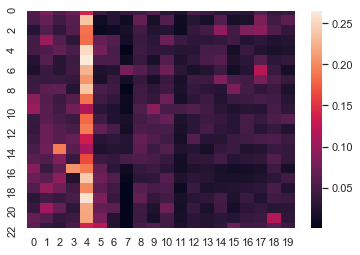

 video_shift index 0 at 01:56 , chapter title Graph Theory ( index 4) 
 video_shift index 1 at 05:03 , chapter title Graph Theory ( index 4) 
 video_shift index 2 at 08:12 , chapter title Graph Theory ( index 4) 
 video_shift index 3 at 12:00 , chapter title Graph Theory ( index 4) 
 video_shift index 4 at 16:07 , chapter title Graph Theory ( index 4) 
 video_shift index 5 at 19:33 , chapter title Graph Theory ( index 4) 
 video_shift index 6 at 25:37 , chapter title Graph Theory ( index 4) 
 video_shift index 7 at 28:21 , chapter title Graph Theory ( index 4) 
 video_shift index 8 at 32:29 , chapter title Graph Theory ( index 4) 
 video_shift index 9 at 37:14 , chapter title Graph Theory ( index 4) 
 video_shift index 10 at 40:07 , chapter title Graph Theory ( index 4) 
 video_shift index 11 at 42:48 , chapter title Graph Theory ( index 4) 
 video_shift index 12 at 46:31 , chapter title Graph Theory ( index 4) 
 video_shift index 13 at 49:57 , chapter title Graph Theory ( index 4) 
 v

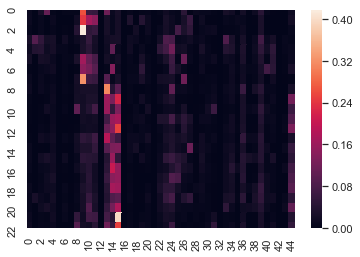

h9wxtqoa1jY


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,01:56,5.2.1 Sex in America,0.264107,5.2.1,Sex in America,None
1,05:03,5.2.1 Sex in America,0.242102,5.2.1,Sex in America,None
2,08:12,5.2.1 Sex in America,0.416789,5.2.1,Sex in America,None
3,12:00,5.1 Definitions,0.091185,5,Graph Theory,None
4,16:07,5.5.3 The Minimum Number of Edges in a Connected Graph,0.120320,5.1.1,Simple Graphs,None
5,19:33,5.2.1 Sex in America,0.166537,5.1.1,Simple Graphs,None
6,25:37,5.2.1 Sex in America,0.145310,5.2.1,Sex in America,None
7,28:21,5.2.1 Sex in America,0.323895,5.2.1,Sex in America,None
8,32:29,5.3.1 An Exam Scheduling Problem,0.313835,5.3.1,An Exam Scheduling Problem,None
9,37:14,5.3.3 Why coloring?,0.221559,5.3.1,An Exam Scheduling Problem,None


################ NuY7szYSXSw ################


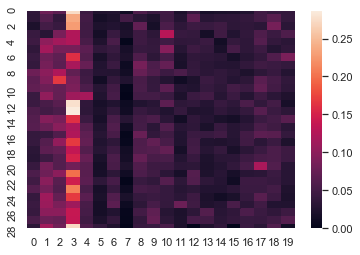

 video_shift index 0 at 02:09 , chapter title Number Theory ( index 3) 
 video_shift index 1 at 03:33 , chapter title Number Theory ( index 3) 
 video_shift index 2 at 05:24 , chapter title Number Theory ( index 3) 
 video_shift index 3 at 07:59 , chapter title Cardinality Rules ( index 10) 
 video_shift index 4 at 10:24 , chapter title Number Theory ( index 3) 
 video_shift index 5 at 13:11 , chapter title Patterns of Proof ( index 1) 
 video_shift index 6 at 16:43 , chapter title Number Theory ( index 3) 
 video_shift index 7 at 19:38 , chapter title Number Theory ( index 3) 
 video_shift index 8 at 21:51 , chapter title Induction ( index 2) 
 video_shift index 9 at 25:10 , chapter title Induction ( index 2) 
 video_shift index 10 at 28:36 , chapter title Number Theory ( index 3) 
 video_shift index 11 at 30:32 , chapter title Graph Theory ( index 4) 
 video_shift index 12 at 33:03 , chapter title Number Theory ( index 3) 
 video_shift index 13 at 35:43 , chapter title Number Theory 

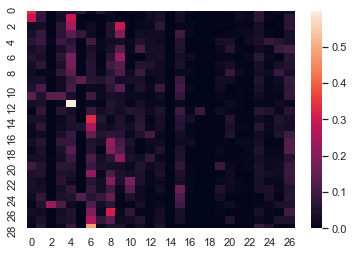

NuY7szYSXSw


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,02:09,Number Theory,0.336015,4,Number Theory,None
1,03:33,4.1.3 Die Hard,0.288874,4,Number Theory,None
2,05:24,4.2.4 One Solution for All Water Jug Problems,0.292641,4,Number Theory,None
3,07:59,4.2.4 One Solution for All Water Jug Problems,0.188818,4,Number Theory,None
4,10:24,4.2.1 Linear Combinations and the GCD,0.098521,4.1,Divisibility,None
5,13:11,4.2.4 One Solution for All Water Jug Problems,0.129432,4.1,Divisibility,None
6,16:43,4.2.4 One Solution for All Water Jug Problems,0.228744,4.1,Divisibility,None
7,19:38,4.1.3 Die Hard,0.174370,4.1,Divisibility,None
8,21:51,4.1.3 Die Hard,0.141445,4.1.3,Die Hard,None
9,25:10,4.2 The Greatest Common Divisor,0.143606,4.1.3,Die Hard,None


################ XX7ePR21Ook ################


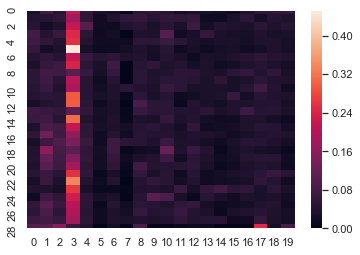

 video_shift index 0 at 01:49 , chapter title Number Theory ( index 3) 
 video_shift index 1 at 03:05 , chapter title Number Theory ( index 3) 
 video_shift index 2 at 04:19 , chapter title Number Theory ( index 3) 
 video_shift index 3 at 06:28 , chapter title Number Theory ( index 3) 
 video_shift index 4 at 08:40 , chapter title Number Theory ( index 3) 
 video_shift index 5 at 11:42 , chapter title Number Theory ( index 3) 
 video_shift index 6 at 13:24 , chapter title Number Theory ( index 3) 
 video_shift index 7 at 16:28 , chapter title Number Theory ( index 3) 
 video_shift index 8 at 19:47 , chapter title Number Theory ( index 3) 
 video_shift index 9 at 23:25 , chapter title Number Theory ( index 3) 
 video_shift index 10 at 25:23 , chapter title Number Theory ( index 3) 
 video_shift index 11 at 29:09 , chapter title Number Theory ( index 3) 
 video_shift index 12 at 32:21 , chapter title Number Theory ( index 3) 
 video_shift index 13 at 34:27 , chapter title Number Theory 

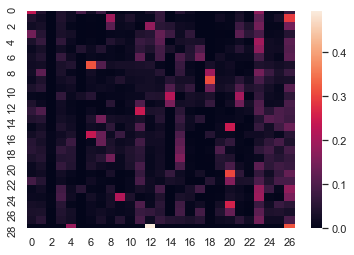

XX7ePR21Ook


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,01:49,Number Theory,0.236333,4.4,Alan Turing,None
1,03:05,4.8 The RSA Algorithm,0.292348,4.4,Alan Turing,None
2,04:19,4.4 The man pictured in Figure,0.180851,4.4,Alan Turing,None
3,06:28,Number Theory,0.142243,4.4,Alan Turing,None
4,08:40,4.7,0.198945,4.4.1,Turing’s Code (Version 1.0),None
5,11:42,4.7,0.174502,4.4.2,Breaking Turing’s Code,None
6,13:24,4.6 Arithmetic with a Prime Modulus,0.138146,4.5.1,Turing’s Code (Version 2.0),None
7,16:28,4.2.1 Linear Combinations and the GCD,0.318308,4.7.1,Relative Primality,None
8,19:47,4.6.1 Multiplicative Inverses,0.194858,4.5,Modular Arithmetic,None
9,23:25,4.6.1 Multiplicative Inverses,0.309969,4.6.1,Multiplicative Invers,None


In [22]:
chapters_matching_topics = {}
#for vid in videos_ids:
for vid in videos_ids:
    print('################ %s ################' % (vid))
    paper_name = video_to_paper[vid]
    correlations_levels = []
    
    
    
    '''Finding the correlation between topic and main chapters'''
    main_matching_topic,correlation = get_topic_chapter_corr_tfidf(paper_name,
                                 paper_mains_as_one_doc[paper_name],
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 paper_content[paper_name]['main titles'])
    
    correlations_levels.append(correlation)
    #print(main_matching_topic)
    dominet_chapter =  find_dominent_main_chapter(main_matching_topic,
                                                  paper_content[paper_name]['main titles'],
                                                 correlation)
    print('By the majority vote, the dominent chapter choosed is %s ' %(dominet_chapter))
    
    #Searching for each topic the most correlated 
    #subsection to a topic within the dominent main chapter '''
    dom_main_cha_index = paper_content[paper_name]['main titles'].index(dominet_chapter)
    dom_subsec_text = [paper_subsec_as_one_doc[paper_name][s_i] for s_i in
                      paper_sec_within_main_indexes[paper_name][dom_main_cha_index]]
    dom_subsec_titles = [paper_content[paper_name]['titles'][tl]
                         for tl in paper_sec_within_main_indexes[paper_name][dom_main_cha_index]]
    
    dom_subsec_text = emphasize_title(paper_name,dom_subsec_text,
                                      dom_subsec_titles,lemmatizing = lemmatizing_method)
    
    
    '''Extracting all pre labeled topics '''
    pre_labeled_titles = df_tp_to_ch.loc[df_tp_to_ch['video id'] == vid,
                        ['chapter section','chapter title','chapter confidence']].values.tolist()
    
    subsec_matching_topic,correlation = get_topic_chapter_corr_tfidf(paper_name,
                                 dom_subsec_text,
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 dom_subsec_titles,
                                 pre_labeled_title = pre_labeled_titles)
    
    correlations_levels.append(correlation)
    #measure_confidence(vid,correlations_levels)
    
    
    
    
    